# Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)

# Define functions

In [3]:
def closed_range(start, stop, step=1):
    if step - round(step) == 0:
        aux_delta = 1 if step > 0 else -1
        return [*range(start, stop + aux_delta, step)]
    else:
        aux_delta = step/100
        step_decimal_places = len(str(step).split(".")[1])
        return np.round(np.arange(start, stop + aux_delta, step), step_decimal_places).tolist()

# Read data

In [4]:
train_data = pd.read_csv("../data/clean/train.csv")
test_data = pd.read_csv("../data/clean/test.csv")

# Prepare data

In [5]:
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

X_train, y_train = train_data.loc[:,[col for col in train_data.columns if col != 'price']], train_data['price']

# Apply missing imputation and target encoding
nm_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
ct_features = X_train.select_dtypes(include=['object']).columns.tolist()
features_to_target_encode = ['property_type']

nm_missing_value_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
ct_missing_value_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')

target_encoder = TargetEncoder(target_type='continuous')

column_transformer_missing_imputation = ColumnTransformer(
    transformers=[
        ('nm_missing_value_imputer',
         nm_missing_value_imputer,
         nm_features),
        ('ct_missing_value_imputer',
         ct_missing_value_imputer,
         [feature for feature in ct_features if feature not in features_to_target_encode]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

column_transformer_target_encoding = ColumnTransformer(
    transformers=[
        ('target_encoder',
         target_encoder,
         slice(-1, None)),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

pipeline = Pipeline(
    steps=[
        ('column_transformer_missing_imputation', column_transformer_missing_imputation),
        ('column_transformer_stage_2', column_transformer_target_encoding)
    ]
)

X_train_t = pipeline.fit_transform(X_train, y_train) 
X_train_t = pd.DataFrame(X_train_t, columns=pipeline.get_feature_names_out())

# Use dict vectorizer to apply one hot encoding
dict_vectorizer = DictVectorizer(sparse=False)
X_train_t = dict_vectorizer.fit_transform(X_train_t.to_dict(orient='records'))
X_train_t = pd.DataFrame(X_train_t, columns=dict_vectorizer.feature_names_)

In [6]:
X_train_t.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,58191.0000,4.5742,3.1862,1.0000,2.0000,4.0000,6.0000,16.0000
availability_30,58191.0000,15.4012,11.1656,0.0000,4.0000,15.0000,27.0000,30.0000
availability_365,58191.0000,222.7097,113.2878,0.0000,124.0000,244.0000,334.0000,365.0000
availability_60,58191.0000,35.2261,20.6088,0.0000,18.0000,37.0000,56.0000,60.0000
availability_90,58191.0000,58.2029,28.8048,0.0000,38.0000,64.0000,85.0000,90.0000
bathrooms,58191.0000,1.6326,1.0933,0.0000,1.0000,1.0000,2.0000,25.5000
bedrooms,58191.0000,1.8591,1.3619,0.0000,1.0000,1.0000,3.0000,24.0000
beds,58191.0000,2.4335,2.1698,0.0000,1.0000,2.0000,3.0000,132.0000
calculated_host_listings_count,58191.0000,20.2416,67.3837,1.0000,1.0000,3.0000,12.0000,569.0000
calculated_host_listings_count_entire_homes,58191.0000,18.3032,67.2098,0.0000,1.0000,2.0000,9.0000,569.0000


In [7]:
# Check a row
X_train_t.iloc[146,:]

accommodates                                     7.0000
availability_30                                 30.0000
availability_365                               200.0000
availability_60                                 60.0000
availability_90                                 90.0000
bathrooms                                        2.5000
bedrooms                                         3.0000
beds                                             4.0000
calculated_host_listings_count                   3.0000
calculated_host_listings_count_entire_homes      3.0000
calculated_host_listings_count_private_rooms     0.0000
calculated_host_listings_count_shared_rooms      0.0000
city=austin                                      1.0000
city=chicago                                     0.0000
city=dallas                                      0.0000
city=los angeles                                 0.0000
city=san diego                                   0.0000
has_availability_flag                           

# Train models

## Linear regression

In [8]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_train_t.values, np.log10(y_train))

In [9]:
dict(zip(dict_vectorizer.feature_names_, ["{:.6f}".format(value) for value in lr_model.coef_]))

{'accommodates': '0.023762',
 'availability_30': '0.003640',
 'availability_365': '-0.000007',
 'availability_60': '0.000143',
 'availability_90': '-0.000377',
 'bathrooms': '0.070787',
 'bedrooms': '0.040049',
 'beds': '-0.004261',
 'calculated_host_listings_count': '0.003073',
 'calculated_host_listings_count_entire_homes': '-0.002755',
 'calculated_host_listings_count_private_rooms': '-0.005896',
 'calculated_host_listings_count_shared_rooms': '-0.007275',
 'city=austin': '0.109836',
 'city=chicago': '3.469574',
 'city=dallas': '0.799934',
 'city=los angeles': '-2.376716',
 'city=san diego': '-2.002629',
 'has_availability_flag': '0.040477',
 'host_acceptance_rate': '0.000140',
 'host_email_verified_flag': '0.001889',
 'host_has_profile_pic_flag': '0.016163',
 'host_identity_verified_flag': '-0.013418',
 'host_is_superhost_flag': '0.008453',
 'host_phone_verified_flag': '-0.171117',
 'host_response_rate': '0.000172',
 'host_response_time=a few days or more': '0.037529',
 'host_respo

In [10]:
lr_model.intercept_

-35.38985842860165

## ElasticNet regression

In [11]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

en_model = ElasticNet(alpha=1, tol=1)
en_param_distributions = dict(l1_ratio=closed_range(0,1,0.1))

en_random_search = GridSearchCV(
    estimator=en_model,
    param_grid=en_param_distributions,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=4)

en_model_hyper = en_random_search.fit(X_train_t.values, np.log10(y_train))

In [12]:
en_model_hyper.best_params_

{'l1_ratio': 0.0}

## Random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestRegressor(n_estimators=50)
rf_param_distributions = dict(
    max_depth=closed_range(10,30,5),
    min_samples_split=closed_range(2,10),
    min_samples_leaf=closed_range(1,5)
    )

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_distributions,
    scoring='neg_mean_squared_error',
    n_iter=5,
    cv=5,
    n_jobs=4,
    random_state=123)

rf_model_hyper = rf_random_search.fit(X_train_t.values, np.log10(y_train))

In [14]:
rf_model_hyper.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30}

# Evaluate models

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

X_test, y_test = test_data.loc[:,[col for col in test_data.columns if col != 'price']], test_data['price']

X_test_t = pipeline.transform(X_test)
X_test_t = pd.DataFrame(X_test_t, columns=pipeline.get_feature_names_out())

X_test_t = dict_vectorizer.transform(X_test_t.to_dict(orient='records'))
X_test_t = pd.DataFrame(X_test_t, columns=dict_vectorizer.get_feature_names_out())

In [16]:
mean_squared_error_results = {
    'Linear regression': 
    mean_squared_error(np.log10(y_test), lr_model.predict(X_test_t.values)),
    'ElasticNet regression': 
    mean_squared_error(np.log10(y_test), en_model_hyper.predict(X_test_t.values)),
    'Random forest': 
    mean_squared_error(np.log10(y_test), rf_model_hyper.predict(X_test_t.values))
} 

mean_squared_error_results

{'Linear regression': 0.05191146463063092,
 'ElasticNet regression': 0.06414082831103111,
 'Random forest': 0.027740354644663786}

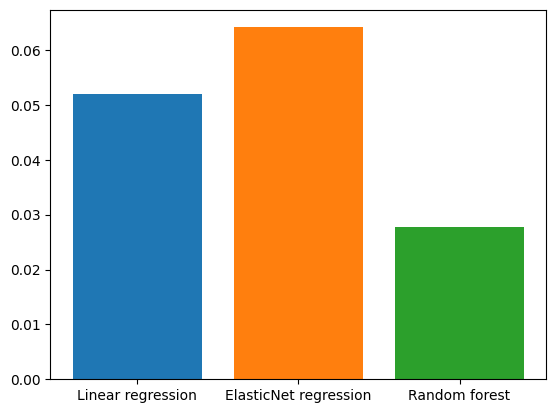

In [17]:
plt.bar(list(mean_squared_error_results.keys()),
        list(mean_squared_error_results.values()),
        color=['tab:blue','tab:orange','tab:green'])
plt.show()